Load libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand 
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row

from pyspark.mllib.classification import *
from pyspark.mllib.regression import *

In [3]:
print('Running Spark version {0}'.format(sc.version))

Running Spark version 2.4.0

##Load Data

In [5]:
AWS_ACCESS_KEY="AWS_ACCESS_KEY"
AWS_SECRET_KEY="AWS_SECRET_KEY"
ENCODED_SECRET_KEY = AWS_SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = "aws-reviews-dataset"
MOUNT_NAME = "aws-reviews-dataset"

dbutils.fs.mount("s3a://%s:%s@%s" % (AWS_ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

--------------------------------------------------------------------------- 
 ExecutionError Traceback (most recent call last)
 <command-2048787319722192> in <module> () 
 5 MOUNT_NAME = "aws-reviews-dataset" 
 6 
 ----> 7 dbutils . fs . mount ( "s3a://%s:%s@%s" % ( AWS_ACCESS_KEY , ENCODED_SECRET_KEY , AWS_BUCKET_NAME ) , "/mnt/%s" % MOUNT_NAME ) 
 8 display ( dbutils . fs . ls ( "/mnt/%s" % MOUNT_NAME ) ) 
 9 S3_MOUNT_POINT = "/mnt/aws-reviews-dataset/amazon_cells_labelled.txt" 

 /local_disk0/tmp/1555818542569-0/dbutils.py in f_with_exception_handling (*args, **kwargs) 
 302 exc . __context__ = None 
 303 exc . __cause__ = None 
 --> 304 raise exc 
 305 return f_with_exception_handling 
 306 

 ExecutionError : An error occurred while calling o296.mount.
: java.rmi.RemoteException: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/aws-reviews-dataset; nested exception is: 
	java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/aws-reviews-dataset
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:100)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:54)
	at com.databricks.backend.daemon.dbutils.DBUtilsCore.mount(DBUtilsCore.scala:454)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.IllegalArgumentException: requirement failed: Directory already mounted: /mnt/aws-reviews-dataset
	at scala.Predef$.require(Predef.scala:281)
	at com.databricks.backend.daemon.data.server.DefaultMetadataManager.insertMount(MetadataManager.scala:127)
	at com.databricks.backend.daemon.data.server.handler.MountHandler.receive(MountHandler.scala:66)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1(SessionContext.scala:83)
	at com.databricks.backend.daemon.data.server.session.SessionContext.$anonfun$queryHandlers$1$adapted(SessionContext.scala:82)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at com.databricks.backend.daemon.data.server.session.SessionContext.queryHandlers(SessionContext.scala:82)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:272)
	at com.databricks.backend.daemon.data.server.DbfsServerBackend$$anonfun$receive$3.applyOrElse(DbfsServerBackend.scala:252)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$2(ServerBackend.scala:42)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:58)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:58)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$1(ServerBackend.scala:38)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$2(UsageLogging.scala:359)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:235)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:230)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:227)
	at com.databricks.rpc.ServerBackend.withAttributionContext(ServerBackend.scala:13)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:268)
	

In [6]:
S3_MOUNT_POINT="/mnt/aws-reviews-dataset/amazon_cells_labelled.txt"

In [7]:
rdd=sc.textFile(S3_MOUNT_POINT)
rdd.take(5)

Out[ 9 ]: 
['So there is no way for me to plug it in here in the US unless I go by a converter.\t0',
 'Good case, Excellent value.\t1',
 'Great for the jawbone.\t1',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0',
 'The mic is great.\t1']

##Build DataFrame from Data

In [9]:
# Split a review sentence and label
rdd1 = rdd.map(lambda x: x.split("\t"))
rdd1.take(5)

Out[4]: 
[['So there is no way for me to plug it in here in the US unless I go by a converter.',
 '0'],
 ['Good case, Excellent value.', '1'],
 ['Great for the jawbone.', '1'],
 ['Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 '0'],
 ['The mic is great.', '1']]

In [10]:
rdd2 = rdd1.map(lambda x: Row(review=x[0], label=x[1]))
rdd2.take(5)

Out[5]: 
[Row(label='0', review='So there is no way for me to plug it in here in the US unless I go by a converter.'),
 Row(label='1', review='Good case, Excellent value.'),
 Row(label='1', review='Great for the jawbone.'),
 Row(label='0', review='Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!'),
 Row(label='1', review='The mic is great.')]

In [11]:
# convert RDD to dataframe
df = sqlContext.createDataFrame(rdd2)
df.registerTempTable("df")
df = df.withColumn("label",df.label.cast(DoubleType()))
df.show()

+-----+--------------------+
label| review|
+-----+--------------------+
 0.0|So there is no wa...|
 1.0|Good case, Excell...|
 1.0|Great for the jaw...|
 0.0|Tied to charger f...|
 1.0| The mic is great.|
 0.0|I have to jiggle ...|
 0.0|If you have sever...|
 1.0|If you are Razr o...|
 0.0|Needless to say, ...|
 0.0|What a waste of m...|
 1.0|And the sound qua...|
 1.0|He was very impre...|
 0.0|If the two were s...|
 1.0|Very good quality...|
 0.0|The design is ver...|
 1.0|Highly recommend ...|
 0.0|I advise EVERYONE...|
 1.0| So Far So Good!.|
 1.0| Works great!.|
 0.0|It clicks into pl...|
+-----+--------------------+
only showing top 20 rows

##Save the Dataframe to Parquet File

In [13]:
dbutils.fs.mkdirs("/mnt/parquet/amazon_reviews_classification")
df.write.mode("overwrite").format("parquet").save("/mnt/parquet/amazon_reviews_classification")

In [14]:
%fs ls /mnt/parquet/amazon_reviews_classification

path,name,size
dbfs:/mnt/parquet/amazon_reviews_classification/_committed_2434177550894711420,_committed_2434177550894711420,409
dbfs:/mnt/parquet/amazon_reviews_classification/_committed_953141515708685419,_committed_953141515708685419,409
dbfs:/mnt/parquet/amazon_reviews_classification/_started_2434177550894711420,_started_2434177550894711420,0
dbfs:/mnt/parquet/amazon_reviews_classification/part-00000-tid-2434177550894711420-274ed4e4-3577-43d3-b360-639a3c4d44f5-5-1-c000.snappy.parquet,part-00000-tid-2434177550894711420-274ed4e4-3577-43d3-b360-639a3c4d44f5-5-1-c000.snappy.parquet,19925
dbfs:/mnt/parquet/amazon_reviews_classification/part-00001-tid-2434177550894711420-274ed4e4-3577-43d3-b360-639a3c4d44f5-6-1-c000.snappy.parquet,part-00001-tid-2434177550894711420-274ed4e4-3577-43d3-b360-639a3c4d44f5-6-1-c000.snappy.parquet,20163


##Create Table from Parquet File

In [16]:
%sql
CREATE TEMPORARY TABLE amazon
USING PARQUET
OPTIONS (path "/mnt/parquet/amazon_reviews_classification")

##Query the Temp Table(amazon)

In [18]:
%sql
SELECT * FROM amazon limit 100;

label,review
1.0,Thanks again to Amazon for having the things I need for a good price!
1.0,I ended up sliding it on the edge of my pants or back pockets instead.
1.0,I had to go to a store and bought a new NOKIA phone which is working great.
1.0,Works great!.
0.0,REALLY UGLY.
0.0,"horrible, had to switch 3 times."
1.0,The noise shield is incrediable.
0.0,No real improvement.
1.0,Razr Battery - Good buy.
1.0,Keep up the good work Amazon!!


In [19]:
%sql
select review as review from amazon group by review order by count(*) desc limit 25

review
"If you like a loud buzzing to override all your conversations, then this phone is for you!"
Great Phone.
Don't buy this product.
Excellent product for the price.
Works great.
Works great!.
Does not fit.
Great phone.
Great phone!.
This is a great deal.


In [20]:
%sql 
select label, count(1) as count
from amazon
group by label
order by label desc

label,count
1.0,500
0.0,500


##Feature extraction

In [22]:
#convert the distinct labels in the input dataset to index values
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)

#tokenizer
#break review sentence into individual words, remove all non-word characters including symbol like ,?,! etc
tokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\W")

df_tokenized = tokenizer.transform(df)

#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_removed = remover.transform(df_tokenized)

#convert to TF words vector
hashingTF= HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)

#convert to TF*IDF words vector
idf=IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)
for features_label in df_idf.select("features","label").take(3):
  print(features_label)

Row(features=SparseVector(262144, {21872: 5.8101, 52801: 6.2156, 61625: 5.5225, 113100: 4.4238, 172477: 4.9628, 199255: 4.8293}), label=0.0)
Row(features=SparseVector(262144, {113432: 2.5913, 117481: 3.5766, 192310: 3.5076, 206496: 5.117}), label=1.0)
Row(features=SparseVector(262144, {138356: 2.3238, 138642: 5.5225}), label=1.0)

##Split data Train(80%) and Test(20%)

In [24]:
(train, test)=df.randomSplit([0.8,0.2], seed=0)
#cache the train and test data in-memory
train = train.cache()
test = test.cache()

print('Sample number in the train set: {}'.format(train.count()))
print('Sample number in the test set: {}'.format(test.count()))

train.groupby('label').count().toPandas()

Sample number in the train set: 808
Sample number in the test set: 192
Out[18]: 
 label count
0 0.0 407
1 1.0 401

##Data modeling

we will train the data using five classifiers:
Logistic Regression, Naive Bayes, Decision Tree, Random Forest and Gradient Boosted Tree

1.Logistic Regression

In [28]:
def grid_search(p1,p2,p3,p4):
  lr = LogisticRegression()
  pipeline = Pipeline(stages=[labelIndexer,tokenizer,remover,hashingTF,idfModel, lr])
  
  #paramgrid to wrap multiple parameters
  #p1- number of features for hashingTF
  #p2- regularization parameter for a Logistic Regression classifier
  #p3- ElasticNet mixing parameter for a Logistic Regression clasifier
  #p4- max number of iterations for LR classifier
  paramGrid = (ParamGridBuilder()
                .addGrid(hashingTF.numFeatures,[p1])
                .addGrid(lr.regParam,[p2])
                .addGrid(lr.elasticNetParam,[p3])
                .addGrid(lr.maxIter, [p4])
                .build())
  
  #multiclassevaluator to generate accuracy metric as an evaluator for cross validation
  evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
  
  #cross validation for hyperparameter tuning,
  crossval = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=4)
  ## cross-validation and chosse the best set of parameters.
  cvModel = crossval.fit(train)
  average_score = cvModel.avgMetrics
  print('average cross-validation accuracy = {}'.format(average_score[0]))
  
  return average_score[0]
  

In [29]:
score=0.0
for p1 in [45000,50000,55000]:
  for p2 in [0.09,0.10,0.11]:
    for p3 in [0.09,0.10,0.11]:
      for p4 in [9,10,11]:
        t0 = time()
        print('(numoffeatures,regParam,elasticNetParam,maxIter) = ({},{},{},{})'.format(p1,p2,p3,p4))
        average_score=grid_search(p1,p2,p3,p4)
        training_time=time()-t0
        print("Classifier trained in {} seconds".format(round(training_time,3)))
        if average_score > score:
          print('### Best score ###')
          params=(p1,p2,p3,p4)
          score=average_score

print('Best score is . {} at params={}'.format(score,params))        
        

(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.09,9)
average cross-validation accuracy = 0.8044904445883193
Classifier trained in 22.272 seconds
### Best score ###
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.09,10)
average cross-validation accuracy = 0.7984320542018628
Classifier trained in 24.429 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.09,11)
average cross-validation accuracy = 0.7995531588898619
Classifier trained in 29.424 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.1,9)
average cross-validation accuracy = 0.7946585623654301
Classifier trained in 19.83 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.1,10)
average cross-validation accuracy = 0.7933699025716157
Classifier trained in 22.703 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.1,11)
average cross-validation accuracy = 0.7908573397575454
Classifier trained in 23.386 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.11,9)
average cross-validation accuracy = 0.7983569866410583
Classifier trained in 21.272 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.11,10)
average cross-validation accuracy = 0.7994503605576051
Classifier trained in 20.923 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.09,0.11,11)
average cross-validation accuracy = 0.800646532806409
Classifier trained in 24.613 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.09,9)
average cross-validation accuracy = 0.7983893650278374
Classifier trained in 21.242 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.09,10)
average cross-validation accuracy = 0.7970683268472438
Classifier trained in 23.452 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.09,11)
average cross-validation accuracy = 0.7957946254560027
Classifier trained in 22.232 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.1,9)
average cross-validation accuracy = 0.7995531588898619
Classifier trained in 22.045 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.1,10)
average cross-validation accuracy = 0.8019351926002234
Classifier trained in 20.931 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.1,11)
average cross-validation accuracy = 0.8044200246428417
Classifier trained in 21.9 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.11,9)
average cross-validation accuracy = 0.8018601250394187
Classifier trained in 19.991 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.11,10)
average cross-validation accuracy = 0.8055585493150467
Classifier trained in 20.942 seconds
### Best score ###
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.1,0.11,11)
average cross-validation accuracy = 0.8045125121878522
Classifier trained in 22.304 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.09,9)
average cross-validation accuracy = 0.7982968774828267
Classifier trained in 20.049 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.09,10)
average cross-validation accuracy = 0.8019778817742489
Classifier trained in 21.106 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.09,11)
average cross-validation accuracy = 0.8007390203514195
Classifier trained in 22.994 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.1,9)
average cross-validation accuracy = 0.8006315744038356
Classifier trained in 21.366 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.1,10)
average cross-validation accuracy = 0.8030562972882225
Classifier trained in 21.046 seconds
(numoffeatures,regParam,elasticNetParam,maxIter) = (45000,0.11,0.1,11)
average cross-validation accuracy = 0.8082283564476861
Classifier trained in 22.059 seconds
### Best score ###
(numoffeatures,regParam,elasticNetPar

In [30]:
def Data_modeling(train,test,pipeline,paramGrid):
  evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel",predictionCol="prediction", metricName="accuracy")
  crossval = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           numFolds=4)
  
  cvModel = crossval.fit(train)
  prediction = cvModel.transform(test)
  average_score = cvModel.avgMetrics
  print('average cross-validation accuracy = {}'.format(average_score[0]))
  
  evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel",predictionCol="prediction", metricName="accuracy")
  
  ## calculate accuracy_score
  accuracy_score=evaluator.evaluate(prediction)
  
  print('Accuracy in the test data = {}'.format(accuracy_score))
  
  ##calculate F1 score of the prediction of the test data
  evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction", metricName="f1")
  f1_score=evaluator.evaluate(prediction)
  
  print('F1 score in the test data ={}'.format(f1_score))
  
  #calculate area under ROC for the prediction of the test data
  evaluator_roc=BinaryClassificationEvaluator(labelCol="label",metricName="areaUnderROC")
  
  ROC_score = evaluator_roc.evaluate(prediction)
  print('areaUnderROC in the test data = {}'.format(ROC_score))
  
  ###Print classification_report
  prediction_and_labels = prediction.select("label","prediction")
  y_true=[]
  y_pred =[]
  
  for x in prediction_and_labels.collect():
    xx = list(x)
    try:
      tt = int(x[1])
      pp = int(xx[0])
      y_true.append(tt)
      y_pred.append(pp)
    except:
      continue
  
  target_names = ['neg 0', 'pos 1']
  print(classification_report(y_true,y_pred,target_names=target_names))
  return
  
  

In [31]:
lr = LogisticRegression()

#Build a pipeline

LR_Pipeline = Pipeline(stages=[labelIndexer,tokenizer,remover,hashingTF, idfModel, lr])

#Create ParamGrid for cross Validation
#Best score is . 0.8082283564476861 at params=(45000, 0.11, 0.1, 11)

paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [45000])
             .addGrid(lr.regParam, [0.11])
             .addGrid(lr.elasticNetParam, [0.1])
             .addGrid(lr.maxIter, [11])
             .build())

# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7751044299009306
Accuracy in the test data = 0.7552083333333334
F1 score in the test data =0.7552415362287388
areaUnderROC in the test data = 0.8477788639078958
 precision recall f1-score support

 neg 0 0.77 0.73 0.75 98
 pos 1 0.74 0.78 0.76 94

avg / total 0.76 0.76 0.76 192

2.Naive Bayes

In [33]:
#p1 - num of features
#p2 - smothening parameter for NB classifier
def grid_search(p1,p2):
    nb = NaiveBayes()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, nb])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(nb.smoothing, [p2])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [34]:
score=0.0
for p1 in [35000,40000,55000]:
    for p2 in [0.8,0.9,1.0]:
      t0 = time()
      print ('(numFeatures,smoothing)=({},{})'.format(p1,p2))
      average_score=grid_search(p1,p2)
      tt = time() - t0
      print("Classifier trained in {} seconds".format(round(tt,3)))
      if average_score > score:
        print('################ Best score ######################')
        params=(p1,p2)
        score=average_score
print('Best score is --> {} at params ={}'.format(score, params))

(numFeatures,smoothing)=(35000,0.8)
average cross-validation accuracy = 0.7894602184595552
Classifier trained in 5.629 seconds
################ Best score ######################
(numFeatures,smoothing)=(35000,0.9)
average cross-validation accuracy = 0.7894602184595552
Classifier trained in 5.446 seconds
(numFeatures,smoothing)=(35000,1.0)
average cross-validation accuracy = 0.7894602184595552
Classifier trained in 6.641 seconds
(numFeatures,smoothing)=(40000,0.8)
average cross-validation accuracy = 0.7821683542742506
Classifier trained in 7.435 seconds
(numFeatures,smoothing)=(40000,0.9)
average cross-validation accuracy = 0.7821683542742506
Classifier trained in 5.83 seconds
(numFeatures,smoothing)=(40000,1.0)
average cross-validation accuracy = 0.7821683542742506
Classifier trained in 6.688 seconds
(numFeatures,smoothing)=(55000,0.8)
average cross-validation accuracy = 0.7808473160936569
Classifier trained in 7.846 seconds
(numFeatures,smoothing)=(55000,0.9)
average cross-validation accuracy = 0.7808473160936569
Classifier trained in 7.744 seconds
(numFeatures,smoothing)=(55000,1.0)
average cross-validation accuracy = 0.7808473160936569
Classifier trained in 7.897 seconds
Best score is --> 0.7894602184595552 at params =(35000, 0.8)

In [35]:
nb = NaiveBayes()

#Build a pipeline
NB_Pipeline = Pipeline(stages=[labelIndexer,tokenizer,remover,hashingTF,idfModel,nb])

#create paramGrid for cross-validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures,[35000])
             .addGrid(nb.smoothing,[1.0]).build()
            )

#cross validation for hyperparameter tuning,model prediction and model evaluation
Data_modeling(train,test,pipeline,paramGrid)


average cross-validation accuracy = 0.7647698823605956
Accuracy in the test data = 0.75
F1 score in the test data =0.7500000000000001
areaUnderROC in the test data = 0.8449549256000863
 precision recall f1-score support

 neg 0 0.77 0.73 0.75 99
 pos 1 0.73 0.77 0.75 93

avg / total 0.75 0.75 0.75 192

3.Decision Tree

In [37]:
#p1 - num of features for hashingTF
#p2 - maxdepth of tree
#p3 - minimum number of instance each chid must have after split for a Decision Tree classifier

def grid_search(p1,p2,p3):
  dt = DecisionTreeClassifier(labelCol="indexedLabel", impurity="entropy")
  pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,hashingTF, idfModel, dt])
  
  #create ParamGrid for cross validation
  paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(dt.maxDepth, [p2])
                 .addGrid(dt.minInstancesPerNode, [p3])
                 .build())
  
  # evaluate the model with accuracy 
  evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
  
  #perform cross validation
  crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
  
  cvModel = crossval.fit(train)
  
  # avreage cross-validation accuracy metric
  average_score = cvModel.avgMetrics
  
  print('average cross-validation accuracy = {}'.format(average_score[0]))
  
  return average_score[0]
  

In [38]:
score=0.0
for p1 in [65000,70000,75000]:
    for p2 in [23,24,25]:
        for p3 in [3,4,5]:
          t0 = time()
          print('(numFeatures,maxDepth,minInstancesPerNode)=({},{},{})'.format(p1,p2,p3))
          average_score=grid_search(p1,p2,p3)
          tt = time() - t0
          print("Classifier trained in {} seconds".format(round(tt,3)))
          if average_score > score:
            print('######## Best score ##########')
            params=(p1,p2,p3)
            score=average_score
print('Best score is {} at params ={}'.format(score, params))

(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,3)
average cross-validation accuracy = 0.7592543848839782
Classifier trained in 59.206 seconds
######## Best score ##########
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,4)
average cross-validation accuracy = 0.7456813892114357
Classifier trained in 82.723 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,5)
average cross-validation accuracy = 0.7432367847612104
Classifier trained in 82.096 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,3)
average cross-validation accuracy = 0.7580233726667627
Classifier trained in 60.233 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,4)
average cross-validation accuracy = 0.7468775614602395
Classifier trained in 65.513 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,5)
average cross-validation accuracy = 0.7444503769942201
Classifier trained in 91.118 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,25,3)
average cross-validation accuracy = 0.7541573932853194
Classifier trained in 68.761 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,25,4)
average cross-validation accuracy = 0.7468775614602395
Classifier trained in 69.27 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,25,5)
average cross-validation accuracy = 0.7444503769942201
Classifier trained in 68.674 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,23,3)
average cross-validation accuracy = 0.7592867632707574
Classifier trained in 63.774 seconds
######## Best score ##########
(numFeatures,maxDepth,minInstancesPerNode)=(70000,23,4)
average cross-validation accuracy = 0.7482587087990645
Classifier trained in 66.557 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,23,5)
average cross-validation accuracy = 0.7458141043488392
Classifier trained in 63.055 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,24,3)
average cross-validation accuracy = 0.7593120324605771
Classifier trained in 69.217 seconds
######## Best score ##########
(numFeatures,maxDepth,minInstancesPerNode)=(70000,24,4)
average cross-validation accuracy = 0.7455889016664251
Classifier trained in 67.318 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,24,5)
average cross-validation accuracy = 0.7431617172004057
Classifier trained in 64.533 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,25,3)
average cross-validation accuracy = 0.7593120324605771
Classifier trained in 68.97 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,25,4)
average cross-validation accuracy = 0.7455889016664251
Classifier trained in 70.365 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(70000,25,5)
average cross-validation accuracy = 0.7431617172004057
Classifier trained in 66.354 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,23,3)
average cross-validation accuracy = 0.7579657250901638
Classifier trained in 84.876 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,23,4)
average cross-validation accuracy = 0.7446179321000355
Classifier trained in 76.126 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,23,5)
average cross-validation accuracy = 0.7446179321000355
Classifier trained in 65.588 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,24,3)
average cross-validation accuracy = 0.7580233726667627
Classifier trained in 71.965 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,24,4)
average cross-validation accuracy = 0.7407519527185921
Classifier trained in 67.161 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,24,5)
average cross-validation accuracy = 0.7431617172004057
Classifier trained in 65.469 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,25,3)
average cross-validation accuracy = 0.7580233726667627
Classifier trained in 68.475 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,25,4)
average cross-validation accuracy = 0.7419481249673959
Classifier trained in 67.777 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(75000,25,5)
avera

In [39]:
dt = DecisionTreeClassifier(labelCol="indexedLabel", impurity="entropy")

#Build a pipeline

DT_Pipeline = Pipeline(stages=[labelIndexer,tokenizer,remover, hashingTF, idfModel, dt])

#create ParamGrid for cross validation
#Best score is 0.7593120324605771 at params =(70000, 24, 3)
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures,[70000])
             .addGrid(dt.maxDepth,[24])
             .addGrid(dt.minInstancesPerNode,[3])
             .build())

#Execute 4-fold cross validation for hyperparameter tuning, model prediction, model evaluation

Data_modeling(train, test, pipeline, paramGrid)



average cross-validation accuracy = 0.7822436973829932
Accuracy in the test data = 0.7395833333333334
F1 score in the test data =0.7395833333333333
areaUnderROC in the test data = 0.8443032475290536
 precision recall f1-score support

 neg 0 0.76 0.72 0.74 99
 pos 1 0.72 0.76 0.74 93

avg / total 0.74 0.74 0.74 192

4.Random Forest

In [41]:
#p1- numoffeatures
#p2- numof trees to train 
#p3- max depth of the tree
#p4- min no. of instances each child must have after split

def grid_search(p1,p2,p3,p4):
  rf = RandomForestClassifier(labelCol="indexedLabel", impurity="entropy",seed=5043)
  pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover,hashingTF, idfModel, rf])
  
  #create ParamGrid for cross validation
  paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(rf.numTrees, [p2])
                 .addGrid(rf.maxDepth, [p3])
                 .addGrid(dt.minInstancesPerNode, [p4])
                 .build())
  
  # evaluate the model with accuracy 
  evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
  
  #perform cross validation
  crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
  
  cvModel = crossval.fit(train)
  
  # avreage cross-validation accuracy metric
  average_score = cvModel.avgMetrics
  
  print('average cross-validation accuracy = {}'.format(average_score[0]))
  
  return average_score[0]
  
  

In [42]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [30,31,32]:
        for p3 in [28,29,30]:
          for p4 in [1,2]:
            t0 = time()
          print('(numFeatures,numTrees,maxDepth,minInstancesPerNode)=({},{},{},{})'.format(p1,p2,p3,p4))
          average_score=grid_search(p1,p2,p3,p4)
          tt = time() - t0
          print("Classifier trained in {} seconds".format(round(tt,3)))
          if average_score > score:
            print('######## Best score ##########')
            params=(p1,p2,p3,p4)
            score=average_score
print('Best score is {} at params ={}'.format(score, params))

(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,28,2)
average cross-validation accuracy = 0.7093948365411248
Classifier trained in 72.574 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,29,2)
average cross-validation accuracy = 0.7093948365411248
Classifier trained in 110.442 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,30,2)
average cross-validation accuracy = 0.7141194163781088
Classifier trained in 75.727 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,31,28,2)
average cross-validation accuracy = 0.7341234031115609
Classifier trained in 74.211 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,31,29,2)
average cross-validation accuracy = 0.7354397936768275
Classifier trained in 74.041 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,31,30,2)
average cross-validation accuracy = 0.736728453470642
Classifier trained in 82.592 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,32,28,2)
average cross-validation accuracy = 0.7347040764713537
Classifier trained in 73.951 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,32,29,2)
average cross-validation accuracy = 0.73229431198954
Classifier trained in 77.35 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,32,30,2)
average cross-validation accuracy = 0.7322192444287354
Classifier trained in 78.004 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,30,28,2)
average cross-validation accuracy = 0.7281322310802957
Classifier trained in 76.703 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,30,29,2)
average cross-validation accuracy = 0.7244163868204618
Classifier trained in 78.081 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,30,30,2)
average cross-validation accuracy = 0.7268087313180694
Classifier trained in 78.45 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,31,28,2)
average cross-validation accuracy = 0.7393879498160352
Classifier trained in 76.628 seconds
######## Best score ##########
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,31,29,2)
average cross-validation accuracy = 0.7342333106407775
Classifier trained in 78.583 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,31,30,2)
average cross-validation accuracy = 0.731602991091877
Classifier trained in 80.145 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,32,28,2)
average cross-validation accuracy = 0.7081205840540081
Classifier trained in 78.792 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,32,29,2)
average cross-validation accuracy = 0.7081205840540081
Classifier trained in 79.044 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(50000,32,30,2)
average cross-validation accuracy = 0.7118040499270627
Classifier trained in 80.514 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,30,28,2)
average cross-validation accuracy = 0.7300410518176417
Classifier trained in 80.867 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,30,29,2)
average cross-validation accuracy = 0.732441245520863
Classifier trained in 90.539 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,30,30,2)
average cross-validation accuracy = 0.7300165226364761
Classifier trained in 105.933 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,31,28,2)
average cross-validation accuracy = 0.732903683245916
Classifier trained in 105.581 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,31,29,2)
average cross-validation accuracy = 0.7354059352727401
Classifier trained in 84.066 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,31,30,2)
average cross-validation accuracy = 0.7316545110358406
Classifier train

In [43]:
rf = RandomForestClassifier(labelCol="indexedLabel", impurity="entropy",seed=5043)

#Build a pipeline

RF_Pipeline = Pipeline(stages=[labelIndexer,tokenizer,remover, hashingTF, idfModel, rf])

#Best score is 0.7412434950441716 at params =(55000, 32, 30)

#create paramGrid for Cross-validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures,[55000])
             .addGrid(rf.numTrees,[32])
             .addGrid(rf.maxDepth,[30])
             .addGrid(rf.minInstancesPerNode,[1])
             .build())

#Execute 4-fold cross validation for hyperparameter tuning, model prediction, model evaluation

Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7747867396735059
Accuracy in the test data = 0.75
F1 score in the test data =0.7500000000000001
areaUnderROC in the test data = 0.8409362441620499
 precision recall f1-score support

 neg 0 0.77 0.73 0.75 99
 pos 1 0.73 0.77 0.75 93

avg / total 0.75 0.75 0.75 192

##Summary

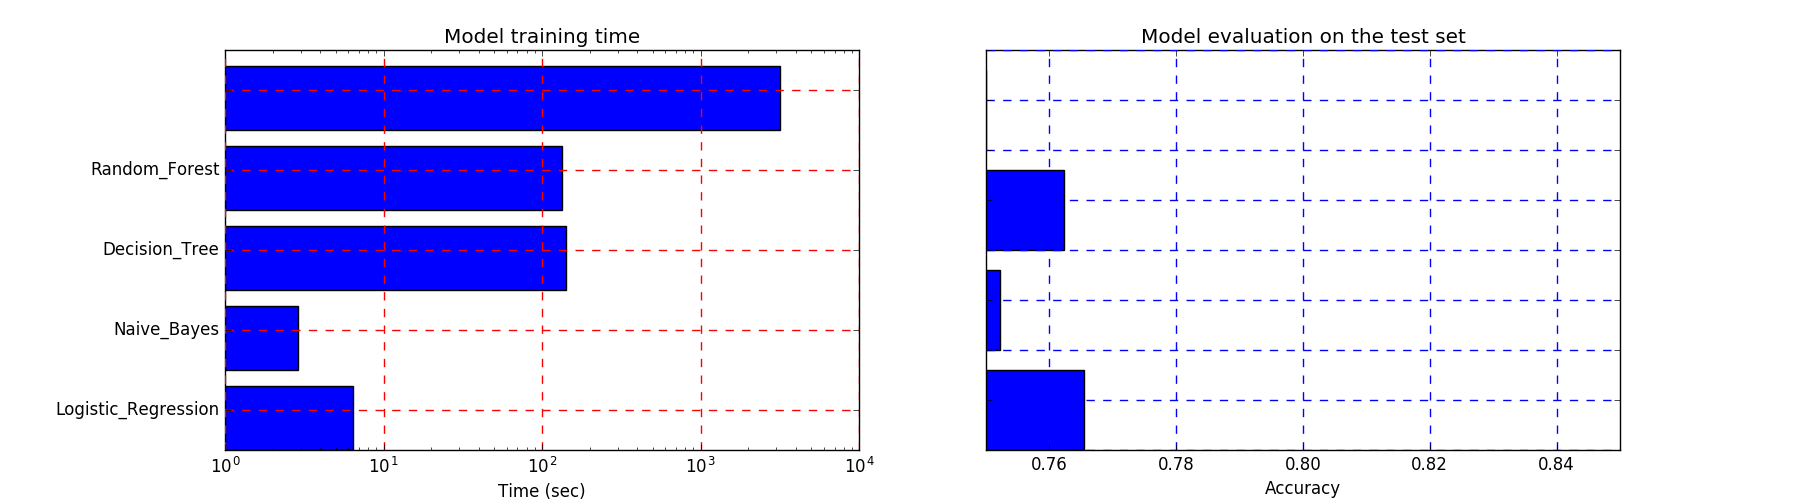

In [45]:
##comparison of all models for amazon review classification
import matplotlib.pyplot as plt
import numpy as np
classifier_names=['Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest']
time=[6.41,2.893,141,133,3179]
accuracy=[0.7654,0.7523,0.7623,0.75]
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5), facecolor='green')
ax[0].barh(np.arange(0, 5),time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='r', linestyle='--', linewidth=1)
ax[0].set_title('Model training time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')

ax[1].barh(range(0, len(classifier_names)),accuracy)
ax[1].set_xlim([0.75,0.85])
ax[1].set_title('Model evaluation on the test set')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)
display(fig)

##Select Model with Higher Accuracy 
##Fit the model
##Evaluate Test Data

In [47]:
#create model estimator
model = LR_Pipeline.fit(train)

#score the model with test data
predictions= model.transform(test)

#convert dataframe into table to query using SQL
predictions.createOrReplaceTempView('tmp_predictions')


###View Prediction of Reviews

In [49]:
%sql
select label,prediction,probability,review from tmp_predictions 
where review like "%not%"

label,prediction,probability,review
0.0,0.0,"List(1, 2, List(), List(1.0, 7.643458801990848E-19))",Do not make the same mistake as me.
0.0,0.0,"List(1, 2, List(), List(0.9999999999999984, 1.644212301121273E-15))","However-the riingtones are not the best, and neither are the games."
0.0,0.0,"List(1, 2, List(), List(1.0, 1.3659327906771868E-17))",I came over from Verizon because cingulair has nicer cell phones.... the first thing I noticed was the really bad service.
0.0,1.0,"List(1, 2, List(), List(1.2614097403461717E-10, 0.9999999998738591))",I did not bother contacting the company for few dollar product but I learned the lesson that I should not have bought this form online anyway.
0.0,1.0,"List(1, 2, List(), List(0.06738802700400336, 0.9326119729959966))",Its not user friendly.
0.0,0.0,"List(1, 2, List(), List(0.9999999999999876, 1.2525240461290125E-14))",The holster that arrived did not match the photo in the ad.
0.0,0.0,"List(1, 2, List(), List(0.9999970872115937, 2.912788406171492E-6))",There's really nothing bad I can say about this headset.
0.0,0.0,"List(1, 2, List(), List(1.0, 3.6628487069933356E-28))",They do not care about the consumer one bit.
0.0,1.0,"List(1, 2, List(), List(5.71926204286105E-13, 0.999999999999428))","My phone sounded OK ( not great - OK), but my wife's phone was almost totally unintelligible, she couldn't understand a word being said on it."
0.0,0.0,"List(1, 2, List(), List(1.0, 5.007540190159936E-41))","Product is useless, since it does not have enough charging current to charge the 2 cellphones I was planning to use it with."


##Persist the model

In [51]:
model.write().overwrite().save("/mnt/prasanna/amazon_review_model")

In [52]:
%fs ls '/mnt/prasanna/amazon_review_model'

path,name,size
dbfs:/mnt/prasanna/amazon_review_model/metadata/,metadata/,0
dbfs:/mnt/prasanna/amazon_review_model/stages/,stages/,0


##optimization using SVM To improve the Accuracy

Tokenize

In [55]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)

#tokenizer
tokenizer = Tokenizer(inputCol="review", outputCol="words")
#df_tokenized = tokenizer.transform(df)

#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
#df_removed = remover.transform(df_tokenized)

#df_removed.show(10)


Build Pipeline

In [57]:
pipeline = Pipeline(stages=[tokenizer,remover])
#Fit the Pipeline
review_tokenized = pipeline.fit(df).transform(df).cache()

Adding Ngrams

In [59]:
# add ngram column
n = 3
ngram = NGram(inputCol = 'words', outputCol = 'ngram', n = n)
add_ngram = ngram.transform(review_tokenized)
# count vectorizer and tfidf
cv_ngram = CountVectorizer(inputCol='ngram', outputCol='tf_ngram')
cvModel_ngram = cv_ngram.fit(add_ngram)
cv_df_ngram = cvModel_ngram.transform(add_ngram)

Create TF-IDF matrix

In [61]:
idf_ngram=IDF().setInputCol('tf_ngram').setOutputCol('tfidf_ngram')
tfidfModel_ngram = idf_ngram.fit(cv_df_ngram)
tfidf_df_ngram = tfidfModel_ngram.transform(cv_df_ngram)

Split into Training and Testing Set

In [63]:
# split into training & testing set
splits_ngram = tfidf_df_ngram.select(['tfidf_ngram', 'label']).randomSplit([0.8,0.2],seed=100)
train_ngram = splits_ngram[0].cache()
test_ngram = splits_ngram[1].cache()

Convert Feature Matrix to Labelled Point Vectors

In [65]:
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg

def convert(v):
    if isinstance(v, ml_linalg.SparseVector):
        return mllib_linalg.SparseVector(v.size, v.indices, v.values)
    if isinstance(v, ml_linalg.DenseVector):
        return mllib_linalg.DenseVector(v.values)
    raise ValueError("Unsupported type {0}".format(type(v)))

train_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], convert(row[0])))
test_lb_ngram = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], convert(row[0])))

Fit SVM model of only trigrams

In [67]:
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb_ngram, numIterations, regParam=regParam)

In [68]:
# replace the word with selected ngram
def ngram_concat(text):
    text1 = text.lower()
    for ngram in ngram_list:
        if ngram in text1:
            new_ngram = ngram.replace(' ', '_')
            text1 = text1.replace(ngram, new_ngram)
    return text1
ngram_df = udf(lambda x: ngram_concat(x))
ngram_df = review_tokenized.select(ngram_df('review'), 'label')\
                          .withColumnRenamed('<lambda>(review)', 'review')

Build the final TF-IDF feature matrix

In [70]:
# count vectorizer and tfidf
cv = CountVectorizer(inputCol='filtered', outputCol='count_vect')
cvModel = cv.fit(review_tokenized)
count_vectorized = cvModel.transform(review_tokenized)


idf=IDF(inputCol="count_vect", outputCol="tf")
tfidfModel = idf.fit(count_vectorized)
tfidf_df = tfidfModel.transform(count_vectorized)

Split Dataset into Train and Test

In [72]:
# split into training and testing set
splits = tfidf_df.select(['tf', 'label']).randomSplit([0.8,0.2],seed=100)
train = splits[0].cache()
test = splits[1].cache()

#create labelled-point rdd:
train_lb = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], convert(row[0])))
test_lb = train_ngram.rdd.map(lambda row: LabeledPoint(row[1], convert(row[0])))


Train with SVM classifier

In [74]:
numIterations = 50
regParam = 0.3
svm = SVMWithSGD.train(train_lb, numIterations, regParam=regParam)
scoreAndLabels_test = test_lb.map(lambda x: (float(svm.predict(x.features)), x.label))
score_label_test = spark.createDataFrame(scoreAndLabels_test, ["prediction", "label"])

Regularized(Elastic Net) Logistics Regression

In [76]:
lambda_par = 0.02
alpha_par = 0.3
lr = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('tf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)
lrModel = lr.fit(train)
lr_pred = lrModel.transform(test)

Evaluate SVM model

In [78]:
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
svm_f1 = f1_eval.evaluate(score_label_test)
print("F1 score: %.4f" % svm_f1)

F1 score: 0.9604

Evaluate Logistics Regression Model

In [80]:
f1_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = f1_eval.evaluate(lr_pred)
print("F1 score: %.4f" % lr_f1)

F1 score: 0.7657

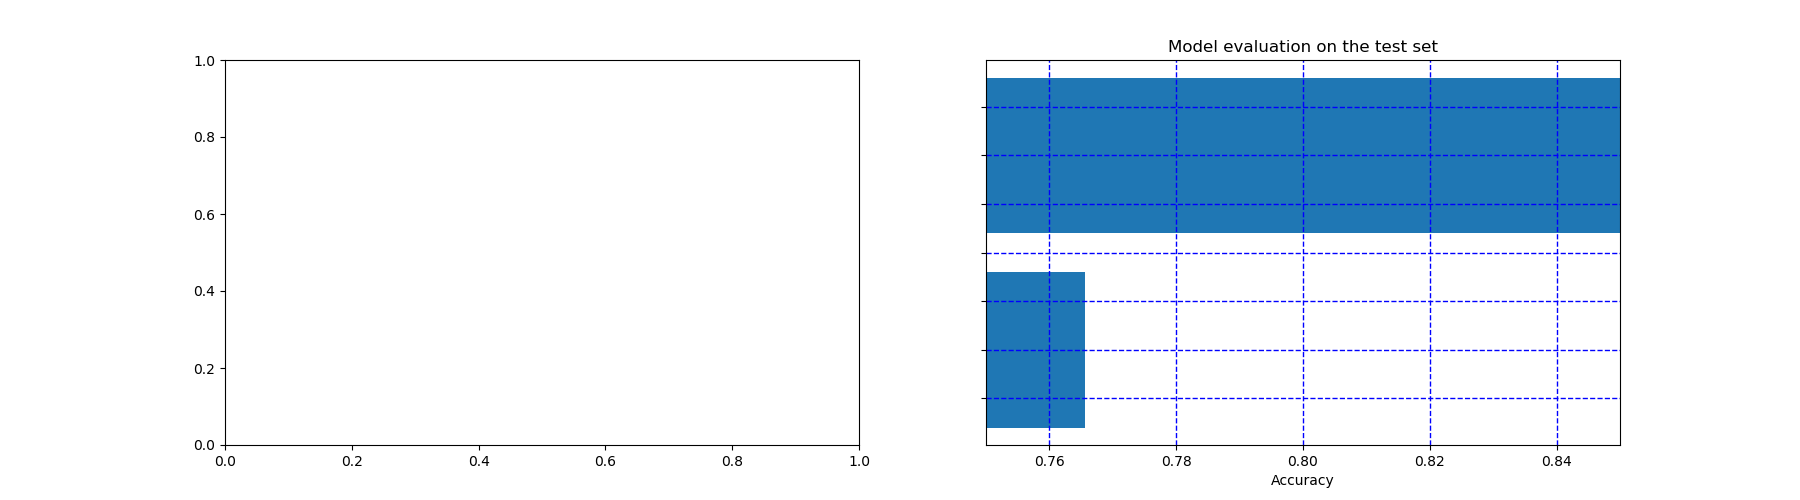

In [81]:
##comparison of all models for amazon review classification
import matplotlib.pyplot as plt
import numpy as np
classifier_names=['Logistic_Regression', 'SVM']
accuracy=[0.7657,0.9604]
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5), facecolor='green')


ax[1].barh(range(0, len(classifier_names)),accuracy)
ax[1].set_xlim([0.75,0.85])
ax[1].set_title('Model evaluation on the test set')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)
display(fig)

##Data Streaming with Kinesis

In [83]:
from pyspark.sql.types import *
from pyspark.sql.functions import from_json

AWS_ACCESS_KEY="AWS_ACCESS_KEY"
AWS_SECRET_KEY="AWS_SECRET_KEY"
kinesisStreamName="aws-scrapper"
kinesisRegion = "ap-southeast-1"


Read Stream and Query using DataFrame

In [85]:
#{'review': 'my name is prasanna', 'reviewId': '1'}

fields = [
  StructField("reviewId", StringType(), True),
  StructField("review", StringType(), True),
  StructField("timeStamp", TimestampType(), True)
  
]

pythonSchema = StructType(fields)

kinesisDF = spark.readStream \
.format("kinesis")\
.option("streamName", kinesisStreamName)\
.option("region", kinesisRegion)\
.option("initialPosition", "latest")\
.option("awsAccessKey", AWS_ACCESS_KEY)\
.option("awsSecretKey", AWS_SECRET_KEY).load()

reviewsDF = kinesisDF.selectExpr("cast (data as STRING) my_json_data").select(from_json("my_json_data", pythonSchema).alias("reviews")).select("reviews.review")

display(reviewsDF)

review
"Apply's easily. Stays put all day. Removes easily with make-up remover or baby wipe. Very affordable. I like to brush the very tip across lashes, from one corner to other. Then use the length of the brush, flat across lashes to separate. The brush is straight, no angles or curves, so application is a cinch. I've strayed, once or twice, to try other brands, but I always come back to this."
"For the price, these are absolutely fine. If you are looking for the perfect headphones check elsewhere though, these definitely are only meant to be budget headphones and you can tell by the audio quality. I was not planning on spending too much and I knew I wouldn't get anything incredible in return. Lived up to my expectations, but nothing more."
I haven't used this yet and I doubt I will since it arrived open and not full. I am nervous putting it on my skin. Will return.
Great !
"Another great value, and product from anker, hope it lasts longer than my ootnz, or however you spell it."
Nice little speaker
"Love the product. Have been searching for the perfect bedside alarm clock, and radio unit. The Echo Spot provides it all and more."
"Alright so i have had these for about 2 weeks now and so far its a 60 40 and i dont know if its because i bought these from a retailer or if its the headset itself. So prior to these ive been using the Logitech G933 wireless and loved those (rgb was worthless but i turned that off) people hated the mic on them but honestly i thought it was perfectly fine. Sound was great i tend to like closed back because it cancels out sound and let me focus more. The mic on these is imo exactly the same like sounds the same and all so no issue there. Sound wise these are open back (atleast thats what it says) and they do have a different sound tone which took some adjustment in the EQ but all is good now though they dont cancel the sound as much as im used to. Comfort Well honestly its about the same. I dont notice any difference between fit apart from these sit straighter on the head then the logis so that they dont kinda slip off when at different angles. But thats about it. Battery life Astro claims to have up to 15 hours of battery life and well. Idk it seems like im having to charge them just as frequently as my logis wirh their ""8"" hour battery life which was right on point for the many years ive been using those. Maybe my time is off but well it doesn't seem like its 15 Wireless range Its much worse then my logis but it's also higher frequency so that makes sense and i dont fault it for that. Base station This is kind of a pain in the ass honestly coming from my logis which had this tiny tiny little usb plug device to work wireless these haslve this big base station that takes up a bunch of space on my desk and charges way to slowly so i have just been using a usb cord thats plugged into a wall port below my desk. Not to mention that the base station has what i can only describe as hard scratches and deep cuts on the top. Definitely not the ""like new"" condition I bought them (headset looks fine but the base station has been through hell and back. Will update in a week or so with my final decision and thoughts."
Has a hard time staying connected to my internet
"Easy to set up, easy to listen to books, or music and set alarms."


Store the Stream in Specific Format

In [87]:
reviewsDF.writeStream.partitionBy("timeStamp") \
  .format("parquet").option("checkpointLocation", "/mnt/prasanna/amazon/amazon-stream-input/checkpoint") \
  .start("/mnt/prasanna/amazon/amazon-stream-input")

Out[ 15 ]: <pyspark.sql.streaming.StreamingQuery at 0x7fb0eac27c88>

In [88]:
base_path = '/mnt/prasanna/amazon/amazon-stream-input-json'
eventsStream = reviewsDF \
  .writeStream \
  .partitionBy('timeStamp') \
  .format('delta') \
  .option('checkpointLocation', base_path + '/_checkpoint') \
  .start(base_path)

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 62 try : 
 ---> 63 return f ( * a , ** kw ) 
 64 except py4j . protocol . Py4JJavaError as e : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 --> 328 format(target_id, ".", name), value)
 329 else : 

 Py4JJavaError : An error occurred while calling o258.start.
: org.apache.spark.sql.AnalysisException: Partition column timeStamp not found in existing columns (review);
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$org$apache$spark$sql$streaming$DataStreamWriter$$normalize$2.apply(DataStreamWriter.scala:536)
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$org$apache$spark$sql$streaming$DataStreamWriter$$normalize$2.apply(DataStreamWriter.scala:536)
	at scala.Option.getOrElse(Option.scala:121)
	at org.apache.spark.sql.streaming.DataStreamWriter.org$apache$spark$sql$streaming$DataStreamWriter$$normalize(DataStreamWriter.scala:536)
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$normalizedParCols$1$$anonfun$apply$1.apply(DataStreamWriter.scala:525)
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$normalizedParCols$1$$anonfun$apply$1.apply(DataStreamWriter.scala:525)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.IterableLike$class.foreach(IterableLike.scala:72)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:54)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$normalizedParCols$1.apply(DataStreamWriter.scala:525)
	at org.apache.spark.sql.streaming.DataStreamWriter$$anonfun$normalizedParCols$1.apply(DataStreamWriter.scala:524)
	at scala.Option.map(Option.scala:146)
	at org.apache.spark.sql.streaming.DataStreamWriter.normalizedParCols(DataStreamWriter.scala:524)
	at org.apache.spark.sql.streaming.DataStreamWriter.start(DataStreamWriter.scala:329)
	at org.apache.spark.sql.streaming.DataStreamWriter.start(DataStreamWriter.scala:242)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:380)
	at py4j.Gateway.invoke(Gateway.java:295)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:251)
	at java.lang.Thread.run(Thread.java:748)


During handling of the above exception, another exception occurred:

 AnalysisException Traceback (most recent call last)
 <command-179829029004179> in <module> () 
 1 base_path = '/mnt/prasanna/amazon/amazon-stream-input-json' 
 ----> 2 eventsStream = reviewsDF . writeStream . partitionBy ( 'timeStamp' ) . format ( 'delta' ) . option ( 'checkpointLocation' , base_path + '/_checkpoint' ) . start ( base_path ) 

 /databricks/spark/python/pyspark/sql/streaming.py in start (self, path, format, outputMode, partitionBy, queryName, **options) 
 1119 return self . _sq ( self . _jwrite . start ( ) ) 
 1120 else : 
 -> 1121 return self . _sq ( self . _jwrite . start ( path ) ) 
 1122 
 1123 @ since ( 2.4 ) 

 /dat

In [89]:
%sql
CREATE TABLE 
IF NOT EXISTS amazon_reviews
USING DELTA 
location '/mnt/prasanna/amazon/amazon-stream-input-json/';

In [90]:
display(reviewsDF)

reviewId,review,timeStamp


In [91]:
%sql select * from amazon_reviews;

reviewId review timeStamp d06906f2 Okay. So you have been seeing people display their Macbooks and you have always fancied owning one of those premium devices. Now, as Amazon offers this Macbook Air at a reduced price, you are getting tempted to buy this. STOP and consider what you get for the money you spend. Do not buy this if you think this adds some premiumness to your profile. It will not - because this device is next in line where support will be withdrawn by Apple. Resist temptation - because THAT is what Apple sells. The last reason to buy should be your feeling that it improves your profile. Apple users will smirk when they see you with an obsolete 'dinosaur' device as they display their latest toys.If you are a windows user - better go to some friend's Macbook and try some activities. MAC OS is great till you try to change something as puny as your mouse cursor!! You realise that you are stuck in the little cozy jail of Apple once you try anything non-standard. Try transferring data by a USB stick from your other laptop to this one .... you will need training. USB partitioning has to be only ExFAT - and evn if you do this partitioning on a MAC, chances are that Windows will not recognise the USB stick. If you are not a power user - this can be a real pain. Of course, you can pretend (like so many thousands of Apple users) that these do not matter. But hey - they do. A premium DELL or HP may be the best option for you. (Yes, I will first discourage you from buying this and then explain why I purchased this for myself)Know that you are giving up the option of buying RAM or SSD from the neighbouring shop to extend the device life. You wil depend on Apple and on Apple alone. Of course there are generic spares - but these too are more expensive than the DELL or HP spares. Once Apple pulls the plug of support, these spares may get even more expensive. In fact, hardware upgrade beyond increasing the SSD is very much a rare luxury. Thankfully, I have kept myself out of this snob-race that Apple peddles.If you are still reading - here are the good sides (why I purchased this in spite of what I wrote above)A Mac is a Mac is a Mac. So is this one. The hardware are perfectly matched and performance is always optimal. This laptop is for carrying along as a second laptop, alongside my official one, a DELL workhorse. MAcbook Air is lightweight and can run other operating systems. I use this to run Windows and Linux.The MAC OS is a very stable Operating system. Chances are that you will never face a single crash in your lifetime of using this Macbook Air. Windows is fragile (too many bugs and updates) and Linux is difficult (you need a little training). That's where the Macbook Air comes in Handy. With Parallels desktop, you can load Linux and Windows on Virtual Machines on the Mac. You can seamlessly go from one OS to another without rebooting. However, note that with 'parallels desktop' you are operating Windows and Linux from your little cell in the Apple jail. And be prepared to shell out a good amount to "buy" this software. It is possible to load linux differently so that it works outside the Apple shell. Quite a saving grace. Using BootCamp (through a dual bootng feature), you can take advantage of the multi-tasking power of Windows without the risk of getting blue screens or hanged functions. So overall that looks great.Now coming back to my rating... I run mostly Windows and Linux on this MAC. Happy with it because the hardware is great. I consider myself a power user - so I know that I can find alternatives for this if and when Apple pulls the plug of support (should be available for at least another year, and a certain period after that as Apple's support to "obsolete" devices). Hence a durability rating of 3 stars only !!That (above) is the truth laid bare. Please decide and buy at your own risk.~~ Buy this if you like the hardware (but know that DELL or HP would give a much better hardware at this price, and those will 

In [92]:
%fs ls /mnt/prasanna/amazon/amazon-stream-input-json/_checkpoint

path,name,size
dbfs:/mnt/prasanna/amazon/amazon-stream-input-json/_checkpoint/commits/,commits/,0
dbfs:/mnt/prasanna/amazon/amazon-stream-input-json/_checkpoint/metadata,metadata,45
dbfs:/mnt/prasanna/amazon/amazon-stream-input-json/_checkpoint/offsets/,offsets/,0


In [93]:
%fs cp -r dbfs:/mnt/prasanna/amazon_review_model file:///tmp/amazon_review_model

res0: Boolean = true

In [94]:

model_path="file:///tmp/amazon_review_model"
model = PipelineModel.load(model_path)

scoredStream = model.transform(reviewsDF).writeStream \
  .format("memory") \
  .queryName("streamPrediction") \
  .start()

In [95]:
#queryStream = scoredStream.writeStream \
 # .format("memory") \
  #.queryName("streamPrediction") \
  #.start()

In [96]:
display (spark.sql("select prediction, probability, review from streamPrediction"))

prediction,probability,review
0.0,"List(1, 2, List(), List(1.0, 2.0661319519868724E-38))","Awesome controller for the Switch. Pro Controller comes almost completely charged. Once you plug in the USB cord, an orange/ambient light comes on. Once it goes off it means the controller is fully charged. No instructions so had to find this information online."
0.0,"List(1, 2, List(), List(1.0, 2.3813107202559882E-20))","This is the best investment I ever made,40 dollar investment and watch anything ever made. You can add all kinds of apps and see movies that are still in the theater,live sports,or anything else you can imagine. I will never go to anything else and I don,t understand why so many people are wasting their money on cable TV when you can watch anything for free. Get it now!!! I have had it for over 2 years you won't be sorry."
1.0,"List(1, 2, List(), List(2.542887298171545E-11, 0.9999999999745712))",VERY GOOD
1.0,"List(1, 2, List(), List(2.680900933838125E-26, 1.0))",This was considerably cheaper than stores. Works great!
1.0,"List(1, 2, List(), List(1.5297254041279586E-48, 1.0))","Good quality, good value and quick delivery!"
0.0,"List(1, 2, List(), List(1.0, 6.710339512187518E-17))",remote stopped working after 2 months


In [97]:
queryStream.status

Out[12]: {'message': 'Stopped', 'isDataAvailable': False, 'isTriggerActive': False}